In [56]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos
from climpyrical.mask import gen_raster_mask_from_vector
import climpyrical.spytialProcess as sp


from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")

rpy2.robjects.packages.Package as a <module 'fields'>

In [57]:
dsold = xr.open_dataset('/home/nannau/nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc')
dsold_max = dsold.rlat.values.max()

ds = xr.open_dataset('./data/processed/pre_processed.nc')
mask = xr.open_dataset('./data/processed/canada_mask_rp.nc')['mask'].values

In [58]:
ds

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    snw      (rlat, rlon) float64 ...

In [59]:
# station_dv = 'RL50 (kPa)'
# dv = 'Rain-RL50'

# station_dv = 'HDD (degC-day)'
# dv = 'heating_degree_days_per_time_period'

station_dv = 'SL50 (kPa)'
dv = 'snw'

df = pd.read_csv('./data/processed/processed_station.csv')
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

# df = df[df[station_dv] != 0.0]

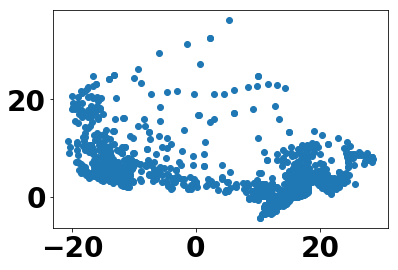

In [60]:
import matplotlib.pyplot as plt
plt.scatter(df.rlon, df.rlat)
plt.show()

In [61]:
df_north = df[df.rlat > dsold_max].copy()
df_no_zero = df[df[station_dv] != 0.0]
df_south = df_no_zero[df_no_zero.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

df

,Unnamed: 0,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,0,558,1009,0.976982,-4.286849,10.373390,42.27560,-82.9556,WINDSOR A,1.078971,0.602379,0.665262
1,1,559,1009,1.228341,-4.227125,10.379271,42.33330,-82.9333,WINDSOR RIVERSIDE,1.348878,0.605814,0.665262
2,2,573,1019,1.520361,-3.597423,10.826373,42.87000,-82.1800,ONR-3603,1.429491,0.707551,0.665262
3,3,573,1025,2.065695,-3.587641,11.086397,42.83000,-81.8300,ONR-3602,1.954558,0.703089,0.665262
4,4,576,1017,1.494511,-3.494586,10.713492,42.99220,-82.3047,SARNIA AIRPORT,1.345183,0.739112,0.665262
...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1310,1322,640,1.232479,29.595134,-5.969464,76.23165,-119.3315,MOULD BAY A,0.623250,1.315559,0.665262
1311,1311,1362,741,1.592493,31.345756,-1.484925,78.78330,-103.5330,ISACHSEN,0.637347,1.662243,0.665262
1312,1312,1391,826,0.893233,32.645419,2.272431,79.98330,-85.9333,EUREKA A,0.305200,1.947032,0.665262
1313,1313,1392,826,1.325107,32.661978,2.269768,80.00000,-85.9300,SCD-NT017,0.452763,1.947032,0.665262


# Krig the station only values in the north

In [62]:
X_n_d =  np.stack([np.deg2rad(df.lat), np.deg2rad(df.lon)]).T

nbrs = NearestNeighbors(n_neighbors=20, metric='haversine').fit(X_n_d)
dist, ind = nbrs.kneighbors(X_n_d)
imax = df.rlat.idxmax(axis=0, skipna=True)
temp_df = df.iloc[ind[imax]]

xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

latlon = np.stack([temp_df.rlon, temp_df.rlat])
stats = temp_df[station_dv]

lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)
ylim = u-lw
xlim = r-l    

z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=True)

final = ds[dv].values.copy()
final[:, :] = np.nan
final[lw:u, l:r] = z.T

nanmask = ~np.isnan(final)

station_final_north = final.copy()

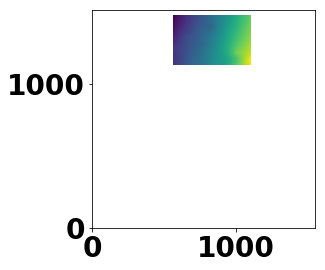

In [63]:
plt.imshow(station_final_north, origin = 'lower')

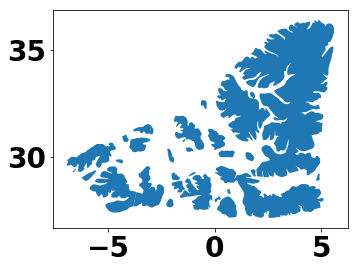

In [64]:
canada = gpd.read_file('./data/processed/canada_final.shp').geometry
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

canada_polygons = MultiPolygon(to_polygons(canada))
polygon_above_north_idx = np.array([p.centroid.y + 1 >= dsold_max for p in canada]) 
M2 = gpd.GeoSeries(MultiPolygon([P for P in canada_polygons if P.centroid.y + 1 >= dsold_max]))
M2.plot()

100%|██████████| 59147/59147 [00:09<00:00, 6455.46it/s]


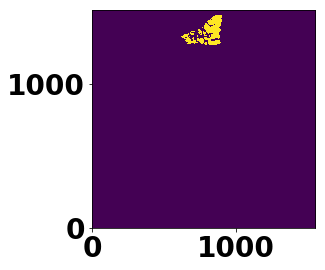

In [65]:
northern_mask = np.zeros(ds[dv].shape) == 1.0
north_ext = 210
northern_mask[-(north_ext+50):, :] = gen_raster_mask_from_vector(
    ds.rlon.values, 
    ds.rlat.values[-(north_ext+50):], 
    M2
)

station_final_north[~northern_mask] = np.nan
plt.imshow(northern_mask, origin='lower')

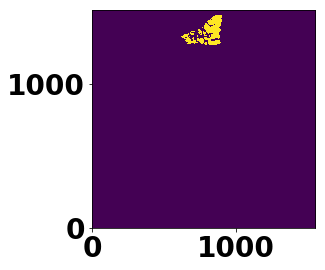

In [66]:
plt.imshow(~np.isnan(station_final_north), origin='lower')

## Find areas in north that are not covered by station only reconstruction

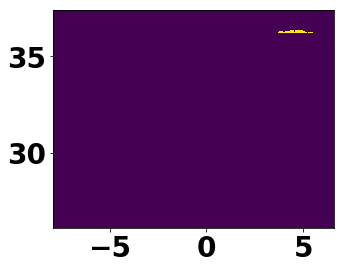

In [67]:
north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

# station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])

station_final_north_filled = station_final_north.copy()
station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

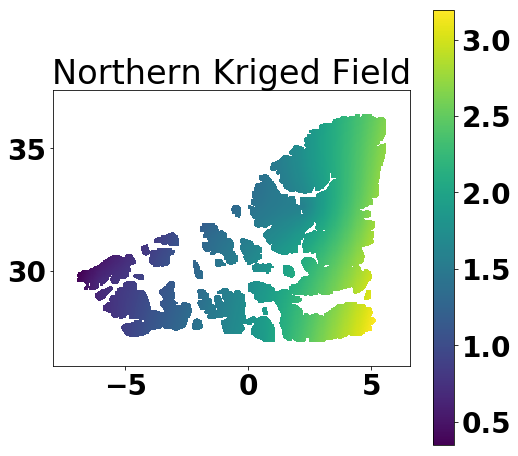

In [68]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(station_final_north_filled, origin='lower', extent = extent)
ax.set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
ax.set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.colorbar(img)
plt.title("Northern Kriged Field")
plt.savefig("northern_krig")

In [69]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix
df
np.any(df.ratio < 0)

False

In [70]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
station_vals = df[station_dv]
best_tol = df.best_tol.mean()    

print(best_tol)

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol

mean_corrected

0.6652619443881096


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [71]:
df

,Unnamed: 0,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,0,558,1009,0.976982,-4.286849,10.373390,42.27560,-82.9556,WINDSOR A,1.078971,0.602379,0.665262
1,1,559,1009,1.228341,-4.227125,10.379271,42.33330,-82.9333,WINDSOR RIVERSIDE,1.348878,0.605814,0.665262
2,2,573,1019,1.520361,-3.597423,10.826373,42.87000,-82.1800,ONR-3603,1.429491,0.707551,0.665262
3,3,573,1025,2.065695,-3.587641,11.086397,42.83000,-81.8300,ONR-3602,1.954558,0.703089,0.665262
4,4,576,1017,1.494511,-3.494586,10.713492,42.99220,-82.3047,SARNIA AIRPORT,1.345183,0.739112,0.665262
...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1310,1322,640,1.232479,29.595134,-5.969464,76.23165,-119.3315,MOULD BAY A,0.623250,1.315559,0.665262
1311,1311,1362,741,1.592493,31.345756,-1.484925,78.78330,-103.5330,ISACHSEN,0.637347,1.662243,0.665262
1312,1312,1391,826,0.893233,32.645419,2.272431,79.98330,-85.9333,EUREKA A,0.305200,1.947032,0.665262
1313,1313,1392,826,1.325107,32.661978,2.269768,80.00000,-85.9300,SCD-NT017,0.452763,1.947032,0.665262


/home/nannau/09092020/climpyrical/climpyrical/gridding.py:360: UserWarning: 21.067501083406015 is outside of array's domain between -4.096673303070716 and 19.69502878238771.             A station is outside of the CanRCM4 model grid space.
  A station is outside of the CanRCM4 model grid space."
/home/nannau/09092020/climpyrical/climpyrical/gridding.py:360: UserWarning: 36.21338637601204 is outside of array's domain between -4.096673303070716 and 19.69502878238771.             A station is outside of the CanRCM4 model grid space.
  A station is outside of the CanRCM4 model grid space."


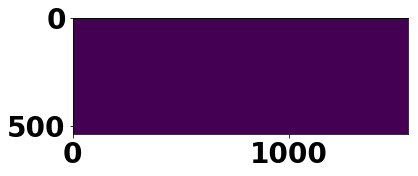

In [72]:
hull = ConvexHull(points=latlon.T)
poly = Polygon(latlon.T[hull.vertices])
poly_mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values[l:r], gpd.GeoSeries(poly), progress_bar=False)
plt.imshow(poly_mask)

In [73]:
ok = OrdinaryKriging(
    df.rlon, 
    df.rlat, 
    df.ratio, 
    exact_values=False,
    variogram_function='exponential',
)
z, ss = ok.execute("grid", ds.rlon.values, ds.rlat.values, backend='C', n_closest_points=40)

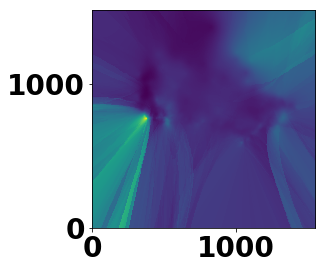

In [74]:
plt.imshow(z, origin='lower')

In [75]:
df[['rlon', 'rlat', 'ratio']].values[:, :2]
import rpy2

rpy2.rinterface_lib.embedded.RRuntimeError

rpy2.rinterface_lib.embedded.RRuntimeError

In [ ]:
Zl = []

X_distances = np.stack([np.deg2rad(df.lat.values), np.deg2rad(df.lon.values)])
dx = ((np.amax(ds.rlon.values)-np.amin(ds.rlon.values))/ds.rlon.size)
dy = ((np.amax(ds.rlat.values)-np.amin(ds.rlat.values))/ds.rlat.size)
dA = dx*dy

xyr = df[['rlon', 'rlat', 'ratio']].values

def krig_at_field(ds, temp_xyr):
        
    xmin, xmax = temp_xyr[:, 0].min(), temp_xyr[:, 0].max()
    ymin, ymax = temp_xyr[:, 1].min(), temp_xyr[:, 1].max()

    latlon = temp_xyr[:, :2].T
    stats = temp_xyr[:, 2]

    lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
    l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)

    ylim = u-lw
    xlim = r-l

    z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=False)

    final = np.ones(ds[dv].values.shape, dtype=np.float16)
    final[:] = np.nan
    final[lw:u, l:r] = z.T
    
    return final

with tqdm(total=len(south_index), position=0, leave=True) as pbar:
    for i in south_index:
        pbar.update()
        nn = 30

        nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
        dist, ind = nbrs.kneighbors(X_distances.T)
        temp_xyr = xyr[ind[i], :]

        latlon = temp_xyr[:, :2]
        stats = temp_xyr[:, 2]
        hull = ConvexHull(points=latlon)
#         poly = Polygon(latlon.T[hull.vertices])

        while hull.area < dA*(3*10)**2:
            nn+=1
            nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
            dist, ind = nbrs.kneighbors(X_distances.T)

            temp_xyr = xyr[ind[i], :]
            latlon = np.stack([temp_df.rlon, temp_df.rlat])

            hull = ConvexHull(points=latlon.T)

        try:
            final = krig_at_field(ds, temp_xyr)
            final_da = da.from_array(final, chunks=(250, 250))
            Zl.append(final_da)

        except rpy2.rinterface_lib.embedded.RRuntimeError:
            continue
            


Exception in thread Thread-36:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 66, in _launch
    self.pid = os.fork

R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.772 1.995 13.98



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.503 0.002 0.516



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.038 0.132 0.379




R Did not converge


R[write to console]: Timing stopped at: 0.151 15.01 228.7



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.217 0.013 0.243



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.022 0.006 0.067



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 1.347 0.016 1.369



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.237 0.001 0.243



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.047 2.987 26.36



R Did not converge


R[write to console]: Error in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead",  : 
  non-finite value supplied by optim

R[write to console]: Timing stopped at: 0.049 0 0.05



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.163 0 0.178



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0
R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0


R[write to console]: Timing stopped at: 0.066 2.025 19.09



R Did not converge


R[write to console]: Timing stopped at: 0.215 2.042 19.11



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.031 0 0.031



R Did not converge


R[write to console]: Error in chol.default(x = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  : 
  the leading minor of order 2 is not positive definite

R[write to console]: Timing stopped at: 0.064 0 0.064



R Did not converge


R[write to console]: Error in chol.default(x = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  : 
  the leading minor of order 2 is not positive definite

R[write to console]: Timing stopped at: 0.06 0 0.06



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 1.347 0.007 1.355



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.525 0 0.533



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 1.747 0.004 1.759



R Did not converge


R[write to console]: Error in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead",  : 
  non-finite value supplied by optim

R[write to console]: Timing stopped at: 0.027 0.005 0.035



R Did not converge


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 1.393 0.008 1.4



R Did not converge


R[write to console]: Error in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead",  : 
  non-finite value supplied by optim

R[write to console]: Timing stopped at: 0.024 0 0.024



R Did not converge




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


From cffi callback <function _processevents at 0x7f9d900d9840>:
Traceback (most recent call last):
From cffi callback <function _processevents at 0x7f9d900d9840>:
  File "/home/nannau/tri/lib/python3.6/site-packages/rpy2/rinterface_lib/callbacks.py", line 265, in _processevents
Traceback (most recent call last):
From cffi callback <function _processevents at 0x7f9d900d9840>:
Traceback (most recent call last):
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
  File "/home/nannau/tri/lib/python3.6/site-packages/rpy2/rinterface_lib/callbacks.py", line 265, in _processevents
  File "/home/nannau/tri/lib/python3.6/site-packages/rpy2/rinterface_lib/callbacks.py", line 265, in _processevents

KeyboardInterrupt

    @ffi_proxy.callback(ffi_proxy._processevents_def,
    @ffi_proxy.callback(ffi_proxy._processevents_def,

From cffi callback <function _processevents a

In [77]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

In [78]:
final = np.zeros(ds[dv].shape)
final_arr = da.stack(Zl, axis=0)
# final_arr = np.stack(np.array(Zl), axis=0)
final = da.nanmean(final_arr, axis = 0)
ratio = final.compute()
# ratio = z.copy()
ratio[~mask] = np.nan

/home/nannau/tri/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


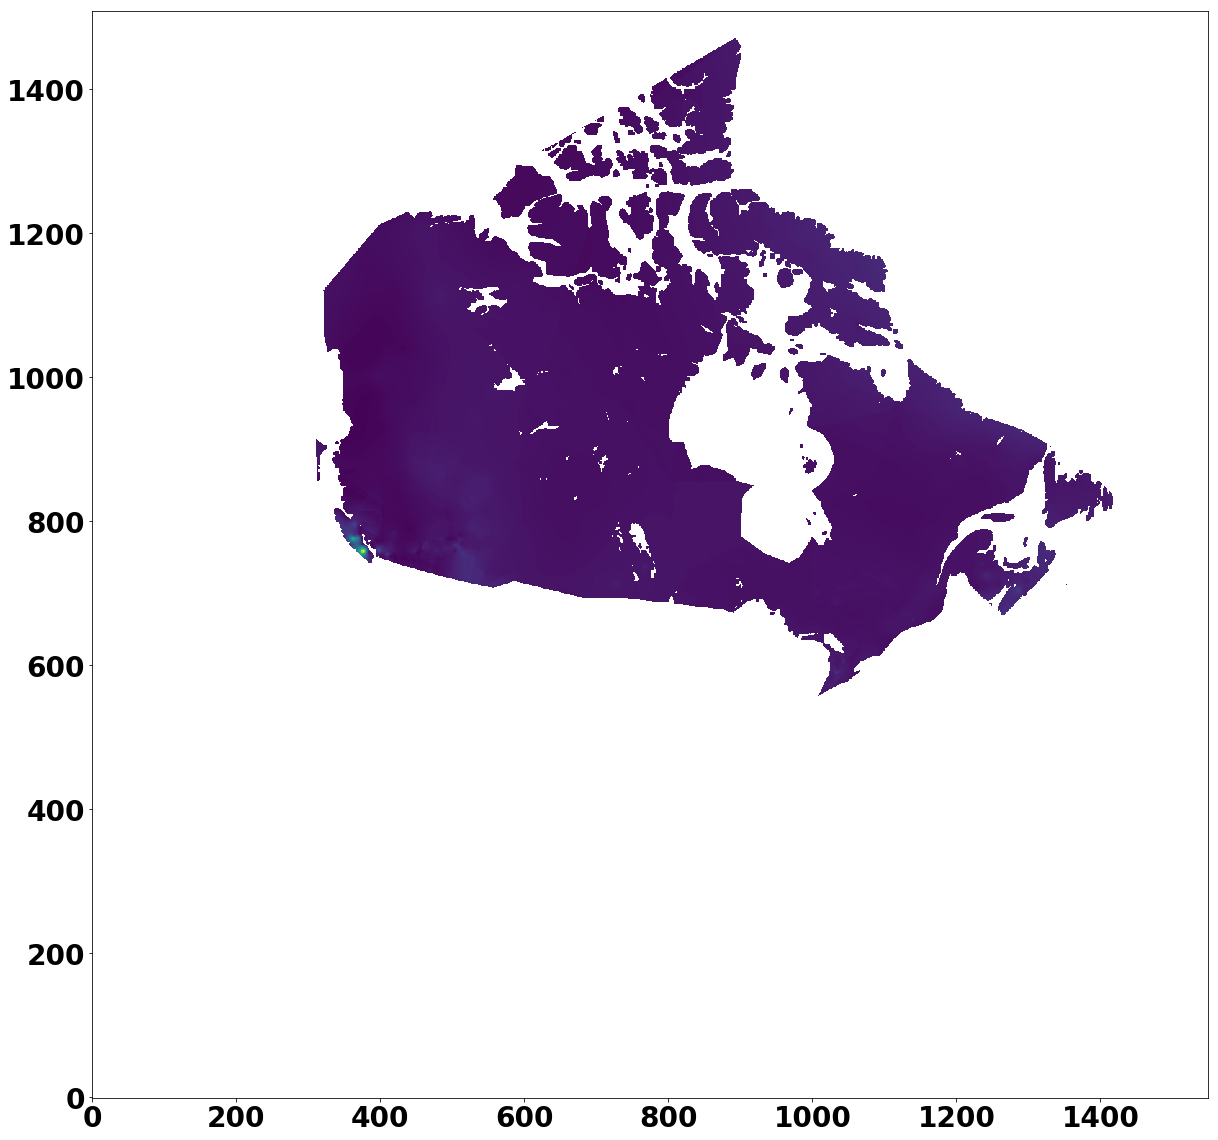

In [79]:
plt.figure(figsize=(20, 20))
plt.imshow(np.array(ratio, dtype=np.float), origin='lower')

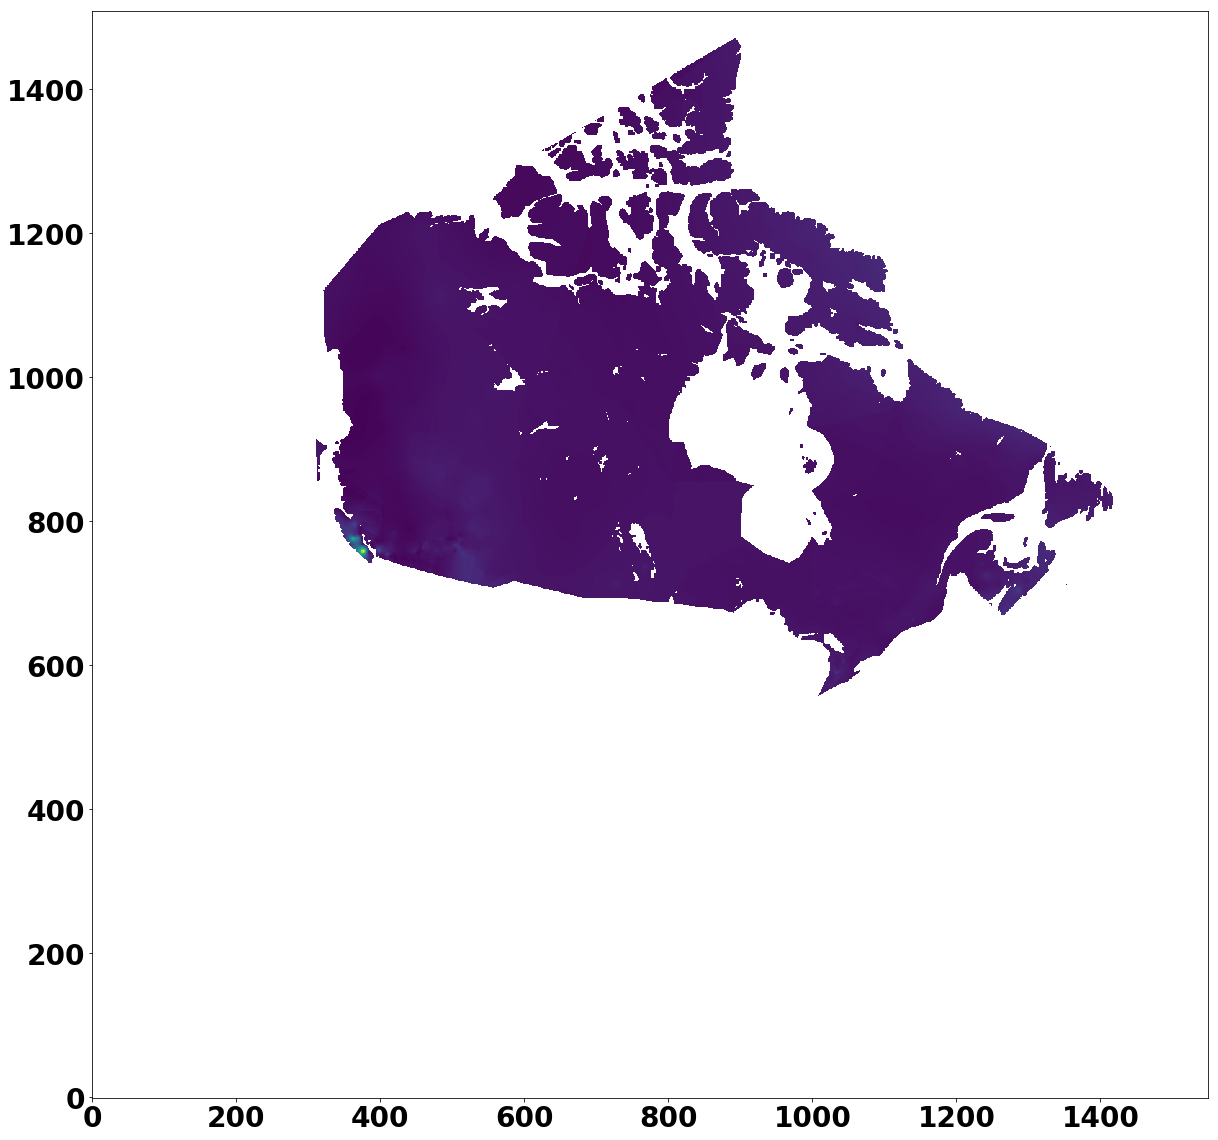

In [80]:
ratio = np.array(ratio, dtype=np.float)
plt.figure(figsize=(20, 20))
plt.imshow(ratio, origin='lower')


/home/nannau/tri/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


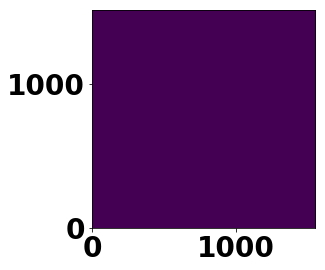

In [81]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])

ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)
ratio_final = ratio_final*mean_corrected

plt.imshow(ratio_final < 0, origin='lower')

In [82]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

In [118]:
np.sum(ratio < 0)

print(canada.geometry.bounds.miny.min(), canada.geometry.bounds.maxy.max())
canada[1].bounds

-4.786119977095354 36.38693291647601


/home/nannau/tri/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(-20.801680964041292,
 2.7139169736444946,
 -11.099795673725668,
 18.14315282432355)

[ 0  6 12 18 24]


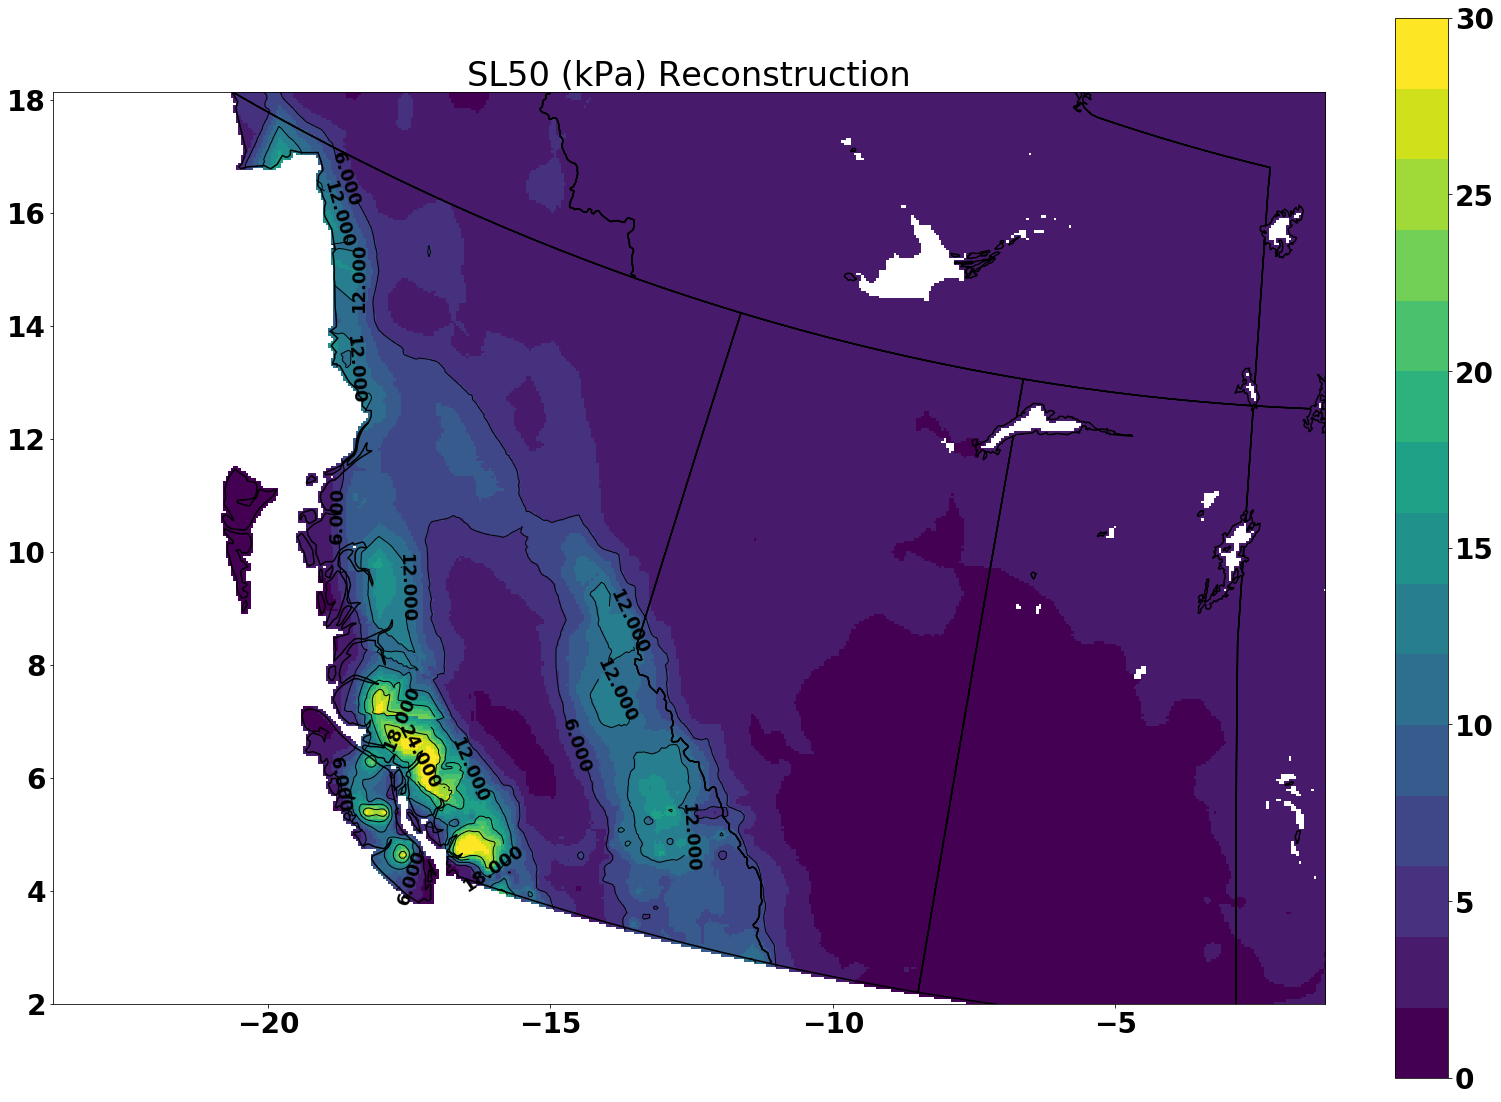

In [129]:
ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
vmin = 0
vmax = 30


N = 15
cont = np.arange(vmin, vmax, 6)
print(cont)

# ax.text(-20, -10, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)))
# ax.text(-20, -12, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)))
# # ax.text(-13, -12, 'Reconstruction Max: {}'.format(np.nanmax(ratio_final)))
# ax.text(-20, -14, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)))


# ax.text(1.5, -10, 'Station Min: {}'.format(np.round(np.min(df[station_dv]), 3)))
# ax.text(1.5, -12, 'Station Max: {}'.format(np.max(df[station_dv])))
# ax.text(1.5, -14, 'Station Mean: {}'.format(np.round(np.nanmean(df[station_dv]), 3)))

# ax.text(17, -10, 'Model Min: {}'.format(np.round(np.nanmin(ds[dv]), 3)))
# ax.text(17, -12, 'Model Max: {}'.format(np.round(np.nanmax(ds[dv]), 3)))
# ax.text(17, -14, 'Model Mean: {}'.format(np.round(np.nanmean(ds[dv]), 3)))

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

# ax.set_xlim(cxmin-1, cxmax+1)
# ax.set_ylim(cymin-1, cymax+1)
# ax.set_ylim(
ax.set_xlim(canada[1].bounds[0]-3, canada[1].bounds[1]-4)
ax.set_ylim(2, canada[1].bounds[3])

# ax.set_xlim(canada[1].geometry.bounds.minx.min()-5, canada[1].geometry.bounds.maxx.max()+5)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Reconstruction')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-BC-full-reconstruction-patched.png')

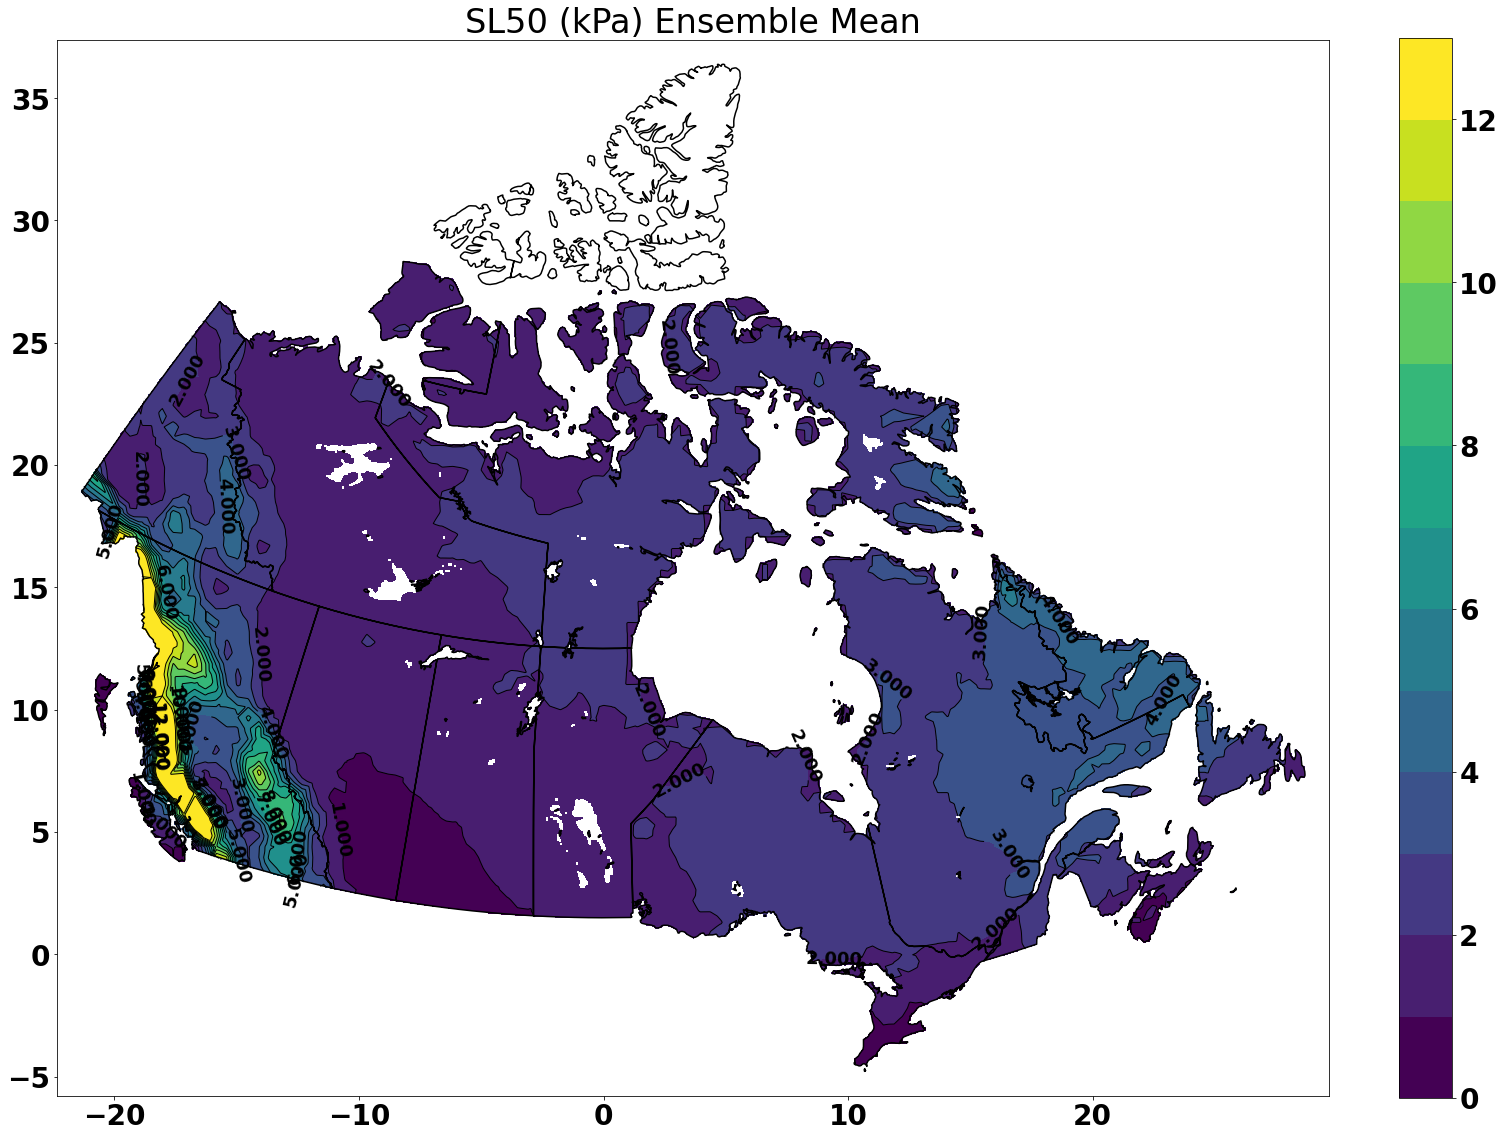

In [28]:
mean = ds[dv].values
mean[~mask] = np.nan
mean[northern_mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 25))



col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Ensemble Mean')
# canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-mean.png')

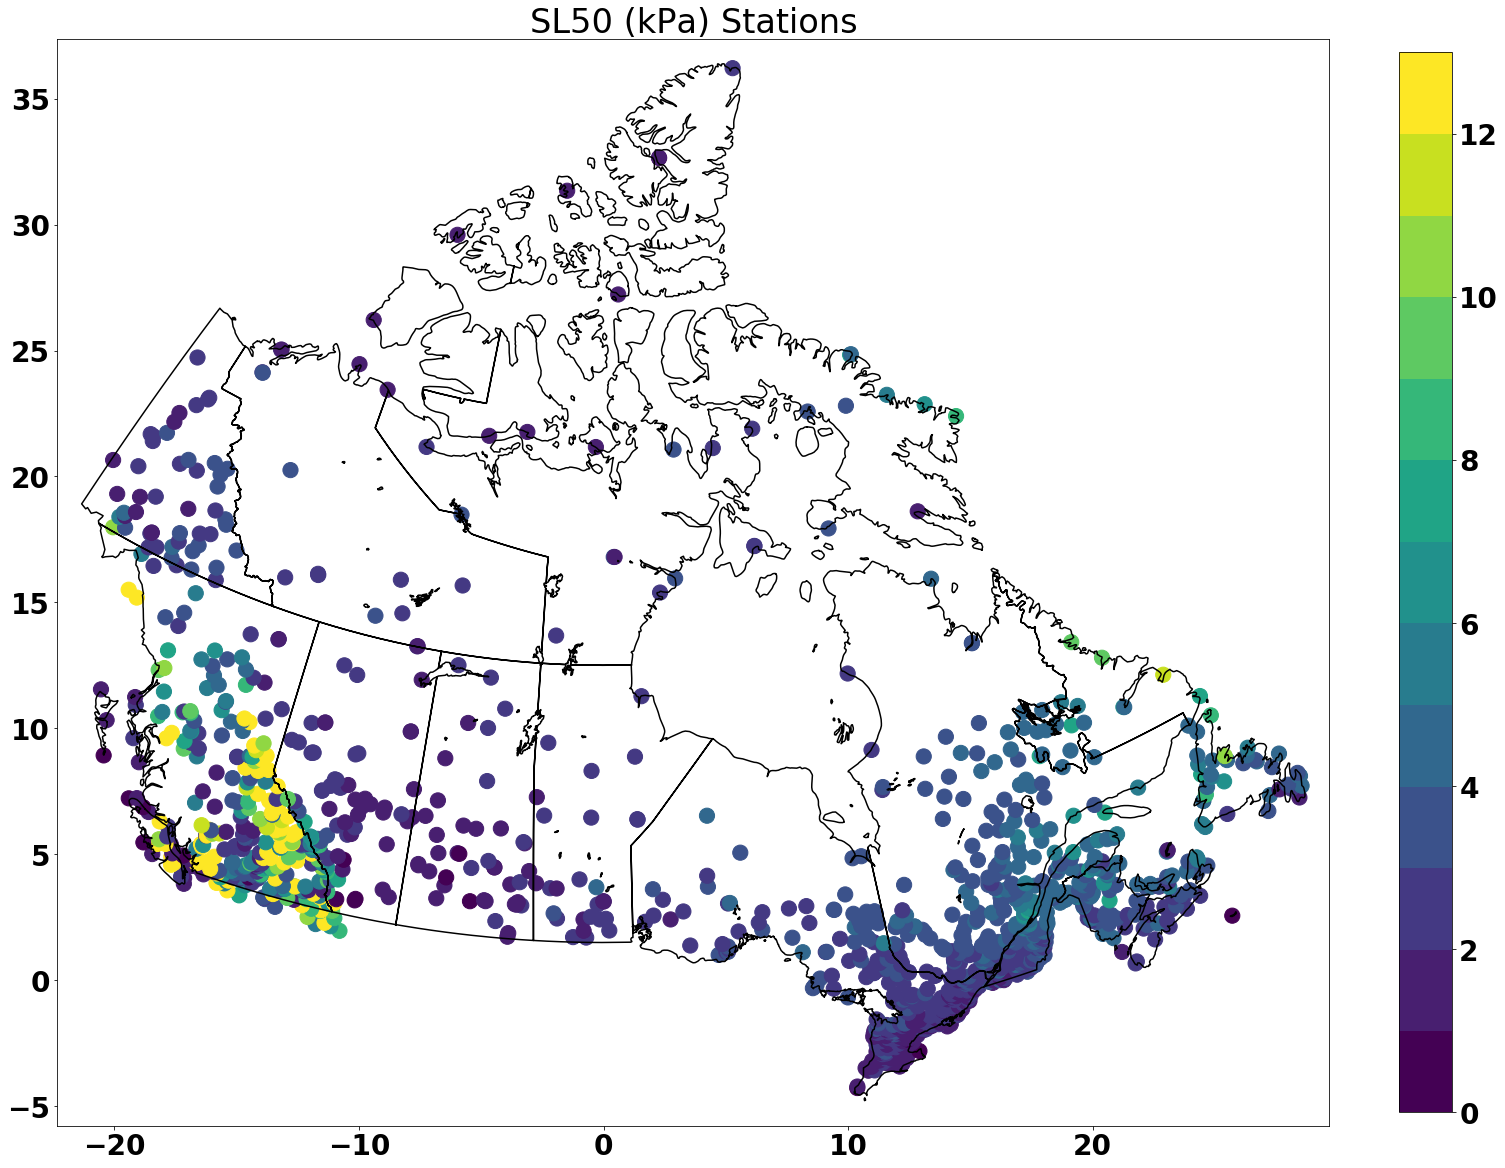

In [87]:
# ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
# ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 20))

sc = ax.scatter(df.rlon, df.rlat, c = df[station_dv], s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap("viridis", N))
plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.set_title(station_dv+' Stations')
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-stations.png')

# Write to Table C-2


In [88]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

# matched_df_nrc[''][np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])] = table_nan
# matched_df_nrc

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table = nrc_table.assign(
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon,
    SL50=design_value)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/processed/table_c2_"+dv+".csv")